In [74]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
import models
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
import viz
from style import *
import analyze_helper
import train
import data_tracks

outcome_def = 'y_consec_sig'
out_dir = 'results/outcome=y_consec_sig'
results = analyze_helper.load_results(out_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# compare all models

**look at prediction metrics**

In [ ]:
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values(by=['accuracy', 'balanced_accuracy'], ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r.style.background_gradient(cmap='viridis', axis=0) # columns differently colored
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])

**look at feat importances**

In [ ]:
r = results
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])
r = r[r.accuracy > 0.65]
keys = [k for k in r if '_f' in k]
keys_remapped = {k: k.replace('_f', '') for k in keys}
r = r[keys].rename(columns=keys_remapped)
# r = r.sort_values('lifetime')
# r = r[r.index.str.contains('39')]
r = r[~r.index.str.contains('=11')]
# r = r[~r.index.str.contains('=7')]
r = r[~r.index.str.contains('=15')]
r = r.rename(columns={'mean_square_displacement': 'msd', 'total_displacement': 'td'})

# r = r[r.index.str.contains('11')]
# r = r[r2.index.str.contains('ros')]
# r = r[r.index.str.contains('none')]
r = r[[k for k in r if not 'std' in k]]


def rank(r):
    '''Rank feature importances appropriately
    '''
    r = r.abs()
    r = r.rank(axis=1, ascending=False, method='min')
    return r
# 
r = rank(r)
r = r.reindex(r.mean().sort_values(ascending=True).index, axis=1) # sort cols by mean rank

idxs = r.index
r.insert(0, 'acc', results.loc[idxs]['accuracy'])
r = r.sort_values('acc', ascending=False)

subset = list(r.keys())
subset.remove('acc')
r.fillna(0).style.background_gradient(cmap='viridis_r', axis=1, subset=subset) # rows differently colored

# analyze model predictions

In [76]:
df = data_tracks.get_data()
n = df.shape[0]
X = df

# normalize and store
X_mean = X.mean()
X_std = X.std()
ks = list(df.keys())
# norms = {ks[i]: {'mu': X_mean[i], 'std': X_std[i]} for i in range(len(ks))}
X = (X - X_mean) / X_std
y = df[outcome_def].values


# split testing data based on cell num
cv_idx = data_tracks.cell_nums_train[0]
idxs_test = df.cell_num.isin([cv_idx]) # this is the cv set for model's trained in the first cv fold
X_test, Y_test = X[idxs_test], y[idxs_test]

# look at best models
r = results
r = r.sort_values('accuracy', ascending=False)
idx = np.array(r.index)
print(idx[:10])

['mlp2_25_ros_select_rf=7' 'mlp2_70_ros_select_rf=7'
 'mlp2_15_ros_select_rf=7' 'svm_15_ros_select_rf=5'
 'mlp2_15_ros_select_rf=5' 'mlp2_70_ros_select_rf=3'
 'svm_25_ros_select_rf=15' 'mlp2_70_ros_select_rf=5'
 'svm_70_ros_select_rf=5' 'mlp2_15_ros_select_rf=3']


### look at single model

In [85]:
model_name = idx[0]
# model_name = 'dt_15_none_select_rf=7'
results_individual = pkl.load(open(oj(out_dir, f'{model_name}.pkl'), 'rb'))
preds, preds_proba = analyze_helper.analyze_individual_results(results_individual, X_test, Y_test, 
                                                print_results=False, plot_results=False)
assert np.mean(preds==Y_test) == results_individual['cv']['accuracy'][0], 'did not properly load model/data'

In [ ]:
viz.viz_errs_lifetime(X_test, preds, preds_proba, Y_test, norms)

In [ ]:
viz.viz_errs_spatially(df, idxs_test, preds, Y_test)

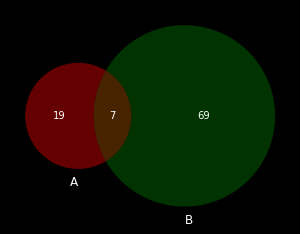

In [86]:
viz.viz_errs_outliers(X_test, preds, Y_test, num_feats_reduced=5)

In [ ]:
idxs_fp = preds > Y_test
idxs_fn = preds < Y_test
print('fp')
viz.viz_biggest_errs(df['X'][idxs_test][idxs_fp], Y_test[idxs_fp], preds[idxs_fp], preds_proba[idxs_fp])    
print('fn')
viz.viz_biggest_errs(df['X'][idxs_test][idxs_fn], Y_test[idxs_fn], preds[idxs_fn], preds_proba[idxs_fn])    

### look at many models

In [7]:
# model_names = ['mlp2_11_none', 'svm_35_none', 'logistic_4_none', 'rf_9_none']
# model_names = ['mlp2_11_none', 'mlp2_9_none', 'mlp2_4_none']
model_names = idx[:12]
df_preds = analyze_helper.load_results_many_models(out_dir, model_names, X_test, Y_test)

['mlp2_70_ros_select_rf=5' 'svm_25_ros_select_rf=11'
 'svm_25_ros_select_rf=7' 'svm_25_ros_select_rf=5'
 'svm_15_ros_select_rf=7' 'svm_25_ros_select_rf=3'
 'svm_70_ros_select_rf=7' 'svm_15_ros_select_rf=3'
 'mlp2_70_ros_select_rf=3' 'mlp2_15_ros_select_rf=5']


**venn-diagram**

In [ ]:
sets = []
for model_name in model_names[:3]:
    args = np.argwhere(df_preds[model_name + '_errs'])
    sets.append(set(args.flatten().tolist()))
    
plt.figure(dpi=300)
plt.title('venn diagram of shared errors')
venn3(sets, model_names[:3])
plt.show()

# ensemble err

**quick check**

In [8]:
df_probas = df_preds[[k for k in df_preds if 'proba' in k]]
preds_test_new = df_probas.sum(axis=1) / (df_probas.shape[1])
preds_labels = preds_test_new > 0.5

print(f'class imbalance {np.mean(Y_test):0.2f}')
print(f'acc {np.mean(Y_test == preds_labels):0.2f}')
print(f'roc_auc {metrics.roc_auc_score(Y_test, preds_labels):0.2f}')
print(f'balanced acc: {metrics.balanced_accuracy_score(Y_test, preds_labels):0.2f}') #' r2 {metrics.r2_score(Y_train, preds):0.2f}')

class imbalance 0.57
acc 0.62
roc_auc 0.62
balanced acc: 0.62


**properly ensemble best models (over folds + models)**

In [ ]:
# split testing data based on cell num
d = {}

kf = KFold(n_splits=5)
cell_nums_train = [1, 2, 3, 4, 5]
Y_vals = []

for i, model_name in enumerate(model_names):
    results_individual = pkl.load(open(f'results/outcome=y_thresh/{model_name}.pkl', 'rb'))

    fold_num = 0
    for cv_idx, cv_val_idx in kf.split(cell_nums_train):
        # get sample indices
        idxs_cv = df.cell_num.isin(cv_idx + 1)
        idxs_val_cv = df.cell_num.isin(cv_val_idx + 1)
        X_train_cv, Y_train_cv = X[idxs_cv], y[idxs_cv]
        X_val_cv, Y_val_cv = X[idxs_val_cv], y[idxs_val_cv]

        # get predictions
        preds, preds_proba = analyze_helper.analyze_individual_results(results_individual, X_val_cv, Y_val_cv, 
                                                    print_results=False, plot_results=False, model_cv_fold=fold_num)
        
        d[f'{model_name}_{fold_num}'] = preds
        d[f'{model_name}_{fold_num}_proba'] = preds_proba
        
        if i == 0:
            Y_vals.append(Y_val_cv)
        
        fold_num += 1

In [124]:
d2 = {}
y_ensemble = np.hstack(Y_vals)
for model_name in model_names:
    d2[model_name] = np.hstack([d[k] for k in d.keys() if model_name in k and 'proba' in k])

In [125]:
d3 = pd.DataFrame.from_dict(d2)
preds_soft = d3.sum(axis=1) / d3.shape[1]

In [133]:
for score_name in train.scorers.keys():
    print(score_name, train.scorers[score_name](y_ensemble, preds_soft > 0.5))
# metrics.accuracy_score(y_ensemble, preds_soft>0.5) 

balanced_accuracy 0.6003315593359517
accuracy 0.6786050895381716
precision 0.7011764705882353
recall 0.8726207906295754
f1 0.7775603392041747
roc_auc 0.6003315593359517
precision_recall_curve (array([0.64373233, 0.70117647, 1.        ]), array([1.        , 0.87262079, 0.        ]), array([False,  True]))
roc_curve (array([0.        , 0.67195767, 1.        ]), array([0.        , 0.87262079, 1.        ]), array([2, 1, 0]))
